In [10]:
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
from random import randrange
from sklearn.svm import SVC

def preprocess():
    """ 
     Input:
     Although this function doesn't have any input, you are required to load
     the MNIST data set from file 'mnist_all.mat'.

     Output:
     train_data: matrix of training set. Each row of train_data contains 
       feature vector of a image
     train_label: vector of label corresponding to each image in the training
       set
     validation_data: matrix of training set. Each row of validation_data 
       contains feature vector of a image
     validation_label: vector of label corresponding to each image in the 
       training set
     test_data: matrix of training set. Each row of test_data contains 
       feature vector of a image
     test_label: vector of label corresponding to each image in the testing
       set
    """

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    n_feature = mat.get("train1").shape[1]
    n_sample = 0
    for i in range(10):
        n_sample = n_sample + mat.get("train" + str(i)).shape[0]
    n_validation = 1000
    n_train = n_sample - 10 * n_validation

    # Construct validation data
    validation_data = np.zeros((10 * n_validation, n_feature))
    for i in range(10):
        validation_data[i * n_validation:(i + 1) * n_validation, :] = mat.get("train" + str(i))[0:n_validation, :]

    # Construct validation label
    validation_label = np.ones((10 * n_validation, 1))
    for i in range(10):
        validation_label[i * n_validation:(i + 1) * n_validation, :] = i * np.ones((n_validation, 1))

    # Construct training data and label
    train_data = np.zeros((n_train, n_feature))
    train_label = np.zeros((n_train, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("train" + str(i)).shape[0]
        train_data[temp:temp + size_i - n_validation, :] = mat.get("train" + str(i))[n_validation:size_i, :]
        train_label[temp:temp + size_i - n_validation, :] = i * np.ones((size_i - n_validation, 1))
        temp = temp + size_i - n_validation

    # Construct test data and label
    n_test = 0
    for i in range(10):
        n_test = n_test + mat.get("test" + str(i)).shape[0]
    test_data = np.zeros((n_test, n_feature))
    test_label = np.zeros((n_test, 1))
    temp = 0
    for i in range(10):
        size_i = mat.get("test" + str(i)).shape[0]
        test_data[temp:temp + size_i, :] = mat.get("test" + str(i))
        test_label[temp:temp + size_i, :] = i * np.ones((size_i, 1))
        temp = temp + size_i

    # Delete features which don't provide any useful information for classifiers
    sigma = np.std(train_data, axis=0)
    index = np.array([])
    for i in range(n_feature):
        if (sigma[i] > 0.001):
            index = np.append(index, [i])
    train_data = train_data[:, index.astype(int)]
    validation_data = validation_data[:, index.astype(int)]
    test_data = test_data[:, index.astype(int)]

    # Scale data to 0 and 1
    train_data /= 255.0
    validation_data /= 255.0
    test_data /= 255.0

    return train_data, train_label, validation_data, validation_label, test_data, test_label


def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def blrObjFunction(initialWeights, *args):
    """
    blrObjFunction computes 2-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector (w_k) of size (D + 1) x 1
        train_data: the data matrix of size N x D
        labeli: the label vector (y_k) of size N x 1 where each entry can be either 0 or 1 representing the label of corresponding feature vector

    Output:
        error: the scalar value of error function of 2-class logistic regression
        error_grad: the vector of size (D+1) x 1 representing the gradient of
                    error function
    """
    train_data, labeli = args

    n_data = train_data.shape[0]
    n_features = train_data.shape[1]

    intercept = np.ones((n_data, 1))
    x = np.hstack((intercept, train_data))
    h = sigmoid(np.dot(x, initialWeights)).reshape(n_data, 1)
    y = labeli

    error = -sum(y * np.log(h) + (1 - y) * np.log(1 - h)) / n_data
    error_grad = np.dot(x.T, (h - y)).reshape(n_features + 1, ) / n_data

    return error, error_grad


def blrPredict(W, data):
    """
     blrObjFunction predicts the label of data given the data and parameter W
     of Logistic Regression

     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D

     Output:
         label: vector of size N x 1 representing the predicted label of
         corresponding feature vector given in data matrix

    """

    n_data = data.shape[0]

    intercept = np.ones((n_data, 1))
    x = np.hstack((intercept, data))

    label = sigmoid(np.dot(x, W))

    return np.argmax(label, axis=1)

In [11]:
"""
Script for Logistic Regression
"""
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# number of classes
n_class = 10

# number of training samples
n_train = train_data.shape[0]

# number of features
n_feature = train_data.shape[1]

Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()
    
W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1, 1))
opts = {'maxiter': 100}

In [ ]:
# Logistic Regression with Gradient Descent
W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1, 1))
opts = {'maxiter': 100}
for i in range(n_class):
    print(i)
    labeli = Y[:, i].reshape(n_train, 1)
    args = (train_data, labeli)
    nn_params = minimize(blrObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    W[:, i] = nn_params.x.reshape((n_feature + 1,))
    
W.dump('params.pickle')
# notice the use of flatten()

predicted_label = blrPredict(W, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label.flatten()))) + '%')

# Find the accuracy on Validation Dataset
predicted_label = blrPredict(W, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label.flatten()))) + '%')

# Find the accuracy on Testing Dataset
predicted_label = blrPredict(W, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label == test_label.flatten()))) + '%')

In [ ]:
"""
Script for Support Vector Machine
"""

print('\n\n--------------SVM-------------------\n\n')

print("Linear")
clf = SVC(kernel='linear')
clf.fit(train_data, train_label)

predicted_label = clf.predict(train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label.flatten()))) + '%')

# Find the accuracy on Validation Dataset
predicted_label = clf.predict(validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label.flatten()))) + '%')

# Find the accuracy on Testing Dataset
predicted_label = clf.predict(test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label == test_label.flatten()))) + '%')

In [ ]:
print("Radial; Gamma: 1")
clf = SVC(kernel='rbf', gamma=1)
clf.fit(train_data, train_label)

predicted_label = clf.predict(train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label.flatten()))) + '%')

# Find the accuracy on Validation Dataset
predicted_label = clf.predict(validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label.flatten()))) + '%')

# Find the accuracy on Testing Dataset
predicted_label = clf.predict(test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label == test_label.flatten()))) + '%')

In [ ]:
print("Radial; Gamma: Default")
clf = SVC(kernel='rbf')
clf.fit(train_data, train_label)

predicted_label = clf.predict(train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label.flatten()))) + '%')

# Find the accuracy on Validation Dataset
predicted_label = clf.predict(validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label.flatten()))) + '%')

# Find the accuracy on Testing Dataset
predicted_label = clf.predict(test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label == test_label.flatten()))) + '%')

In [ ]:
preds = {}

for C in [100]:#[1] + list(np.arange(10, 110, 10)):
    print("Radial; C:", C)
    clf = SVC(C=C)
    clf.fit(train_data, train_label)
    
    preds[C] = {}

    predicted_label = clf.predict(train_data)
    print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label.flatten()))) + '%')
    preds[C]['train'] = 100 * np.mean((predicted_label == train_label.flatten()))

    # Find the accuracy on Validation Dataset
    predicted_label = clf.predict(validation_data)
    print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label.flatten()))) + '%')
    preds[C]['validation'] = 100 * np.mean((predicted_label == validation_label.flatten()))

    # Find the accuracy on Testing Dataset
    predicted_label = clf.predict(test_data)
    print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label == test_label.flatten()))) + '%')
    preds[C]['testing'] = 100 * np.mean((predicted_label == test_label.flatten()))

# Processing Log

In [4]:
accuracies = {
    'logistic': [
        92.724,
        91.46,
        92.0
    ],
    'svm_linear': [
        97.286,
        93.64,
        93.78
    ],
    'svm_gamma_1': [
        100.0,
        15.48,
        17.14
    ],
    'svm_gamma_default': [
        94.294,
        94.02,
        94.42
    ]
}

In [5]:
raw_log = """
08-11 15:20 root         INFO     
 Training set Accuracy:94.294%
08-11 15:22 root         INFO     
 Validation set Accuracy:94.02000000000001%
08-11 15:25 root         INFO     
 Testing set Accuracy:94.42%
08-11 15:35 root         INFO     
 Training set Accuracy:97.13199999999999%
08-11 15:37 root         INFO     
 Validation set Accuracy:96.17999999999999%
08-11 15:38 root         INFO     
 Testing set Accuracy:96.1%
08-11 15:48 root         INFO     
 Training set Accuracy:97.952%
08-11 15:49 root         INFO     
 Validation set Accuracy:96.89999999999999%
08-11 15:50 root         INFO     
 Testing set Accuracy:96.67%
08-11 15:59 root         INFO     
 Training set Accuracy:98.372%
08-11 16:00 root         INFO     
 Validation set Accuracy:97.1%
08-11 16:02 root         INFO     
 Testing set Accuracy:97.04%
08-11 16:11 root         INFO     
 Training set Accuracy:98.706%
08-11 16:12 root         INFO     
 Validation set Accuracy:97.23%
08-11 16:13 root         INFO     
 Testing set Accuracy:97.19%
08-11 16:22 root         INFO     
 Training set Accuracy:99.002%
08-11 16:23 root         INFO     
 Validation set Accuracy:97.31%
08-11 16:24 root         INFO     
 Testing set Accuracy:97.19%
08-11 16:33 root         INFO     
 Training set Accuracy:99.196%
08-11 16:34 root         INFO     
 Validation set Accuracy:97.38%
08-11 16:35 root         INFO     
 Testing set Accuracy:97.16%
08-11 16:44 root         INFO     
 Training set Accuracy:99.33999999999999%
08-11 16:45 root         INFO     
 Validation set Accuracy:97.36%
08-11 16:46 root         INFO     
 Testing set Accuracy:97.26%
08-11 16:55 root         INFO     
 Training set Accuracy:99.438%
08-11 16:56 root         INFO     
 Validation set Accuracy:97.39%
08-11 16:57 root         INFO     
 Testing set Accuracy:97.33000000000001%
08-11 17:06 root         INFO     
 Training set Accuracy:99.542%
08-11 17:07 root         INFO     
 Validation set Accuracy:97.36%
08-11 17:08 root         INFO     
 Testing set Accuracy:97.34%
08-11 17:17 root         INFO     
 Training set Accuracy:99.612%
08-11 17:18 root         INFO     
 Validation set Accuracy:97.41%
08-11 17:19 root         INFO     
 Testing set Accuracy:97.39999999999999% 
"""

In [6]:
Cs = [1] + list(np.arange(10, 110, 10))
accs = []

for n, row in enumerate(raw_log.split('\n')):
    if not n % 2:
        _row = row.split(':')
        if _row[0]:
            _row = float(_row[1].split('%')[0])
            accs.append(_row)

training_accs = []
validation_accs = []
testing_accs = []
for n, a in enumerate(accs):
    if n % 3 == 0:
        training_accs.append(a)
    if n % 3 == 1:
        validation_accs.append(a)
    if n % 3 == 2:
        testing_accs.append(a)

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

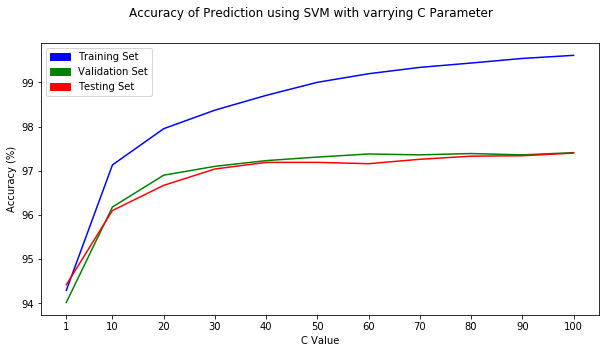

In [9]:
plt.rcParams["figure.figsize"] = [10,5]
plt.plot(Cs, training_accs, 'b-')
plt.plot(Cs, validation_accs, 'g-')
plt.plot(Cs, testing_accs, 'r-')

training_patch = mpatches.Patch(color='b', label='Training Set')
validation_patch = mpatches.Patch(color='g', label='Validation Set')
testing_patch = mpatches.Patch(color='r', label='Testing Set')
plt.legend(handles=[training_patch, validation_patch, testing_patch])

plt.xticks(Cs)
plt.ylabel("Accuracy (%)")
plt.xlabel("C Value")
plt.suptitle("Accuracy of Prediction using SVM with varrying C Parameter")
plt.savefig('fig1.png', dpi = 300)
plt.show()

# Multiclass Logisitic Regression

In [2]:
train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

# number of classes
n_class = 10

# number of training samples
n_train = train_data.shape[0]

# number of features
n_feature = train_data.shape[1]

Y = np.zeros((n_train, n_class))
for i in range(n_class):
    Y[:, i] = (train_label == i).astype(int).ravel()
    
W = np.zeros((n_feature + 1, n_class))
initialWeights = np.zeros((n_feature + 1, 1))
opts = {'maxiter': 100}

In [96]:
def softmax(y_linear):
    exp = np.exp(y_linear-np.max(y_linear, axis=1).reshape((-1,1)))
    norms = np.sum(exp, axis=1).reshape((-1,1))
    return exp / norms

def mlrObjFunction(initialWeights, *args):
    """
    mlrObjFunction computes multi-class Logistic Regression error function and
    its gradient.

    Input:
        initialWeights: the weight vector of size (D + 1) x 1
        train_data: the data matrix of size N x D
        labeli: the label vector of size N x 1 where each entry can be either 0 or 1
                representing the label of corresponding feature vector

    Output:
        error: the scalar value of error function of multi-class logistic regression
        error_grad: the vector of size (D+1) x 10 representing the gradient of
                    error function
    """
    train_data, Y = args

    n_data = train_data.shape[0]
    n_features = train_data.shape[1]

    intercept = np.ones((n_data, 1))
    x = np.hstack((intercept, train_data))
    h = softmax(np.dot(x, initialWeights.reshape(n_features + 1, 10))).reshape(n_data, 10)
    y = Y
    
    error = -sum(sum(y * np.log(h))) / n_data
    error_grad = np.dot(x.T, (h - y)).reshape((n_features + 1)*10, ) / n_data

    return error, error_grad


def mlrPredict(W, data):
    """
     mlrObjFunction predicts the label of data given the data and parameter W
     of Logistic Regression

     Input:
         W: the matrix of weight of size (D + 1) x 10. Each column is the weight
         vector of a Logistic Regression classifier.
         X: the data matrix of size N x D

     Output:
         label: vector of size N x 1 representing the predicted label of
         corresponding feature vector given in data matrix

    """
    n_data = data.shape[0]

    intercept = np.ones((n_data, 1))
    x = np.hstack((intercept, data))

    label = sigmoid(np.dot(x, W))

    return np.argmax(label, axis=1)

In [97]:
"""
Script for Extra Credit Part
"""
# FOR EXTRA CREDIT ONLY
W_b = np.zeros((n_feature + 1, n_class))
initialWeights_b = np.zeros((n_feature + 1, n_class))
opts_b = {'maxiter': 100}

args_b = (train_data, Y)
nn_params = minimize(mlrObjFunction, initialWeights_b, jac=True, args=args_b, method='CG', options=opts_b)
W_b = nn_params.x.reshape((n_feature + 1, n_class))

# Find the accuracy on Training Dataset
predicted_label_b = mlrPredict(W_b, train_data)
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label_b == train_label.flatten()).astype(float))) + '%')

# Find the accuracy on Validation Dataset
predicted_label_b = mlrPredict(W_b, validation_data)
print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label_b == validation_label.flatten()).astype(float))) + '%')

# Find the accuracy on Testing Dataset
predicted_label_b = mlrPredict(W_b, test_data)
print('\n Testing set Accuracy:' + str(100 * np.mean((predicted_label_b == test_label.flatten()).astype(float))) + '%')



 Training set Accuracy:93.448%

 Validation set Accuracy:92.48%

 Testing set Accuracy:92.55%


In [32]:
print(predicted_label_b.sum())

0


In [42]:
nn_params

     fun: 34657.359027999584
     jac: array([  2.00770000e+04,   1.92580000e+04,   2.00420000e+04, ...,
        -2.35294118e-01,   2.35294118e-01,   2.35294118e-01])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 113
     nit: 0
    njev: 101
  status: 2
 success: False
       x: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [72]:
n_data = train_data.shape[0]
n_features = train_data.shape[1]

intercept = np.ones((n_data, 1))
x = np.hstack((intercept, train_data))
h = sigmoid(np.dot(x, initialWeights_b.reshape(n_features + 1, 10))).reshape(n_data, 10)
y = Y

error = -sum(sum(y * np.log(h)))
error_grad = np.dot(x.T, (h - y)).reshape((n_features + 1)*10, )

In [79]:
h.sum(axis=1)[0]

5.0

In [90]:
h/h.sum(axis=1)[:,None]

array([[ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
       ..., 
       [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1],
       [ 0.1,  0.1,  0.1, ...,  0.1,  0.1,  0.1]])

In [59]:
n_data = train_data.shape[0]
n_features = train_data.shape[1]

intercept = np.ones((n_data, 1))
x = np.hstack((intercept, train_data))
h = sigmoid(np.dot(x, initialWeights)).reshape(n_data, 1)
y = Y

error = -sum(sum(y * np.log(h))) / n_data
error_grad = np.dot(x.T, (h - y)).reshape((n_features + 1)*10, ) / n_data


In [63]:
h

array([[0.5],
       [0.5],
       [0.5],
       ...,
       [0.5],
       [0.5],
       [0.5]])

In [62]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


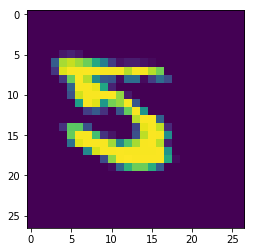

In [50]:
import matplotlib.pyplot as plt
plt.imshow(np.append(train_data[rindex][5], [0]*14).reshape((27,27)))
print(Y[rindex][5])
plt.show()